In [1]:
import numpy as np
import pandas as pd

import os
import cv2

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, utils, models, datasets
from torchsummary import summary

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn import metrics

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
TRAIN_CSV_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../train_images/"
TRAIN = ['../data/train_image_data_0.parquet',
         '../data/train_image_data_1.parquet',
         '../data/train_image_data_2.parquet',
         '../data/train_image_data_3.parquet']

TEST_CSV_PATH = "../data/test.csv"

In [3]:
def Resize(df,size=64):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

In [4]:
resized = []
for fname in TRAIN:
    data = pd.read_parquet(fname)
    data = Resize(data)
    resized.append(data)

image_df = pd.concat(resized, ignore_index = True)

/home2/mlstudent/Grapheme-Classification/ml_pkgs/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [5]:
class GraphemeDataset(Dataset):
    def __init__(self, image_df, label_df, transform=None):
        self.image_df = image_df
        self.label_df = label_df
        self.transform = transform
        
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self,idx):
        label1 = self.label_df.grapheme_root.values[idx]
        label2 = self.label_df.vowel_diacritic.values[idx]
        label3 = self.label_df.consonant_diacritic.values[idx]
        
        image = self.image_df.iloc[idx][1:].values.reshape(64,64).astype(np.float)
        
        if self.transform:
            image = self.transform(image)

        return image,label1,label2,label3

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

In [8]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        
        # grapheme_root
        self.fc1 = nn.Linear(512,168)
        
        # vowel_diacritic
        self.fc2 = nn.Linear(512,11)
        
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

In [29]:
resnet_34 = ResNet34().to(device)
#optimizer = torch.optim.Adam(resnet_34.parameters(), lr=0.00146)
optimizer = torch.optim.SGD(resnet_34.parameters(), lr=4e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [32]:
from torchsummary import summary
summary(resnet_34, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 35, 35]             256
       BatchNorm2d-2           [-1, 64, 35, 35]             128
              ReLU-3           [-1, 64, 35, 35]               0
         MaxPool2d-4           [-1, 64, 35, 35]               0
            Conv2d-5           [-1, 64, 35, 35]          36,864
       BatchNorm2d-6           [-1, 64, 35, 35]             128
              ReLU-7           [-1, 64, 35, 35]               0
            Conv2d-8           [-1, 64, 35, 35]          36,864
       BatchNorm2d-9           [-1, 64, 35, 35]             128
    ResidualBlock-10           [-1, 64, 35, 35]               0
           Conv2d-11           [-1, 64, 18, 18]          36,864
      BatchNorm2d-12           [-1, 64, 18, 18]             128
             ReLU-13           [-1, 64, 18, 18]               0
           Conv2d-14           [-1, 64,

In [26]:
def train(model, optimizer, criterion, scheduler, stratification=False, epochs=32):
    train_validation_df = pd.read_csv(TRAIN_CSV_PATH)

    # TODO:  used for local testing only
    train_validation_df = train_validation_df.sample(frac = 0.1, random_state=0)
    if stratification:
        split = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=0)
    
    else:
        train_df, validation_df = train_test_split(
                train_validation_df, test_size=0.1, random_state=0 
                stratify=train_validation_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']])
    
    train_image = GraphemeDataset(image_df, train_df)
    validation_image = GraphemeDataset(image_df, validation_df)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    

    for epoch in range(epochs):
        print('epochs {}/{} '.format(epoch+1,epochs))
        running_loss = 0.0
        running_acc = 0.0
        validation_loss = 0.0
        validation_acc = 0.0
        
        train_loader = DataLoader(train_image, batch_size=32, shuffle=True)
        validation_loader = DataLoader(validation_image, batch_size=1, shuffle=False)

        model.train(True)
        for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.to(device)

            labels1 = labels1.to(device)
            labels2 = labels2.to(device)
            labels3 = labels3.to(device)

            optimizer.zero_grad()
            outputs1,outputs2,outputs3 = resnet_34(inputs.unsqueeze(1).float().cuda())

            loss1 = criterion(outputs1,labels1)
            loss2 = criterion(outputs2,labels2)
            loss3 = criterion(outputs3,labels3)

            running_loss += loss1+loss2+loss3
            running_acc += (outputs1.argmax(1)==labels1).float().mean()
            running_acc += (outputs2.argmax(1)==labels2).float().mean()
            running_acc += (outputs3.argmax(1)==labels3).float().mean()

            (loss1+loss2+loss3).backward()
            optimizer.step()

        print('train acc : {:.2f}%'.format(running_acc/(len(train_loader)*3)))
        print('train loss : {:.4f}'.format(running_loss/len(train_loader)))

        model.train(False)
        predictions = []
        for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(validation_loader), total=len(validation_loader)):
            inputs = inputs.to(device)
            labels1 = labels1.to(device)
            labels2 = labels2.to(device)
            labels3 = labels3.to(device)

            optimizer.zero_grad()
            outputs1,outputs2,outputs3 = resnet_34(inputs.unsqueeze(1).float().cuda())
            loss1 = criterion(outputs1,labels1)
            loss2 = criterion(outputs2,labels2)
            loss3 = criterion(outputs3,labels3)

            validation_loss += loss1+loss2+loss3
            validation_acc += (outputs1.argmax(1)==labels1).float().mean()
            validation_acc += (outputs2.argmax(1)==labels2).float().mean()
            validation_acc += (outputs3.argmax(1)==labels3).float().mean()

            (loss1+loss2+loss3).backward()
            optimizer.step()
#                 predictions.append([
#                     outputs1.argmax(1).item(),
#                     outputs2.argmax(1).item(),
#                     outputs3.argmax(1).item()
#                ])

    #     predictions_df = pd.DataFrame(predictions, 
    #           columns= ["grapheme_root", "vowel_diacritic", "consonant_diacritic"])

    #     cnf_matrix_grapheme_root = metrics.confusion_matrix(
    #         np.array(validation_df["grapheme_root"]), np.array(predictions_df["grapheme_root"]))

    #     sn.heatmap(cnf_matrix_grapheme_root, annot=True)

    #     cnf_matrix_vowel_diacritic = metrics.confusion_matrix(
    #         np.array(validation_df["vowel_diacritic"]), np.array(predictions_df["vowel_diacritic"]))

    #     sn.heatmap(cnf_matrix_vowel_diacritic, annot=True)

    #     cnf_matrix_consonant_diacritic = metrics.confusion_matrix(
    #         np.array(validation_df["consonant_diacritic"]), np.array(predictions_df["consonant_diacritic"]))

    #     sn.heatmap(cnf_matrix_consonant_diacritic, annot=True)

        print('validation acc : {:.2f}%'.format(validation_acc/(len(train_loader)*3)))

        if running_acc > best_acc:
            best_acc = running_acc
            best_model_wts = resnet_34.state_dict() 

        losses.append(running_loss/len(train_loader))
        accs.append(running_acc/(len(train_loader)*3))
        valid_accs.append(validation_acc/(len(validation_loader)*3))
        valid_losses.append(validation_loss/len(validation_loader))

    resnet_34.load_state_dict(best_model_wts)
    return accs, losses, valid_accs, valid_losses 

In [23]:
def plot_acc_loss(train_acc, train_loss, valid_acc, valid_loss):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].plot(train_loss)
    ax[0].plot(valid_loss)
    ax[0].set_title('loss')
    ax[1].plot(train_acc)
    ax[1].plot(valid_acc)
    ax[1].set_title('acc')

In [27]:
train_acc, train_loss, valid_acc, valid_loss = train(resnet_34, optimizer, criterion, scheduler, epochs=20)

epochs 1/20 


/home2/mlstudent/Grapheme-Classification/ml_pkgs/lib/python3.6/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train acc : 0.29%
train loss : 8.0278


/home2/mlstudent/Grapheme-Classification/ml_pkgs/lib/python3.6/site-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



validation acc : 0.99%
epochs 2/20 



train acc : 0.29%
train loss : 8.0300



validation acc : 1.00%
epochs 3/20 



train acc : 0.29%
train loss : 8.0178



validation acc : 1.01%
epochs 4/20 



train acc : 0.29%
train loss : 8.0179



validation acc : 1.00%
epochs 5/20 



train acc : 0.29%
train loss : 8.0172



validation acc : 1.00%
epochs 6/20 



train acc : 0.29%
train loss : 8.0176



validation acc : 1.00%
epochs 7/20 



train acc : 0.29%
train loss : 8.0184



validation acc : 1.02%
epochs 8/20 



train acc : 0.29%
train loss : 8.0194



validation acc : 1.01%
epochs 9/20 



train acc : 0.29%
train loss : 8.0194



validation acc : 1.00%
epochs 10/20 



train acc : 0.29%
train loss : 8.0184



validation acc : 1.01%
epochs 11/20 



train acc : 0.29%
train loss : 8.0177



validation acc : 1.02%
epochs 12/20 



train acc : 0.29%
train loss : 8.0184



validation acc : 1.02%
epochs 13/20 



train acc : 0.29%
train loss : 8.0166



validation acc : 1.02%
epochs 14/20 



train acc : 0.29%
train loss : 8.0173



validation acc : 1.01%
epochs 15/20 



train acc : 0.29%
train loss : 8.0174



validation acc : 1.01%
epochs 16/20 



train acc : 0.29%
train loss : 8.0174



validation acc : 1.01%
epochs 17/20 



train acc : 0.29%
train loss : 8.0159



validation acc : 1.02%
epochs 18/20 



train acc : 0.29%
train loss : 8.0167



validation acc : 1.02%
epochs 19/20 



train acc : 0.29%
train loss : 8.0162



validation acc : 1.01%
epochs 20/20 



train acc : 0.29%
train loss : 8.0158



validation acc : 1.02%


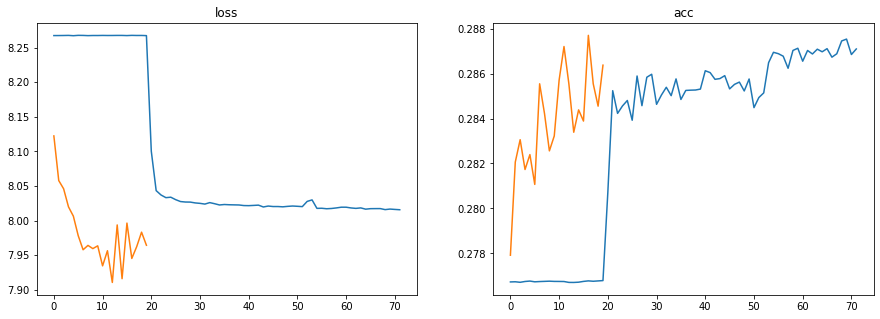

In [28]:
plot_acc_loss(train_acc, train_loss, valid_acc, valid_loss)

In [ ]:
#     train_validation_df = shuffle(train_validation_df)
    #     cut = int(len(train_validation_df)*0.8)
    #     train_df, validation_df = np.split(train_validation_df, [cut], axis=0)